# Домашнее задание 5

Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

**Цель:**
В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

<hr>

Описание/Пошаговая инструкция выполнения домашнего задания:

**Часть 1. Парсинг.**
1. По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется). Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.

**Часть 2. NLP.**
1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
4. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

<hr>

Критерии оценки:
Получилось написать работающий парсер - 4 балла.
Предобработка текста при помощи tf-idf - 2 балла.
Построение моделей и визуализация результатов - 4 балла.

# Часть 1. Парсинг.

Для сбора информации я выбрала сайт с отзовами о московских поликлиниках и врачах https://infodoctor.ru/reviews

Данный сайт содержит отзовы за период от 26 мая 2023 г (когда я начала парсинг) и до 2018. Кол-во страниц 27 379 по 15 отзывов на странице. Для учебного примера я собрала данные с 9 126 страниц (примерно 1/3 всех страниц).

Сайт выглядит следующим образом (пример одного отзыва):

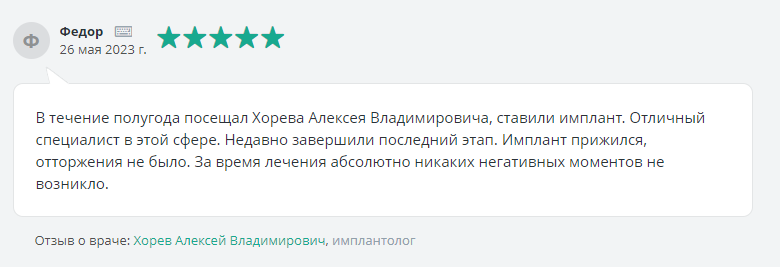

Собирать буду имя пользователя, дату отзыва, оценку, о ком оставлен отзыв (target) и сам отзыв.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
import fake_useragent
import time
import warnings
warnings.filterwarnings("ignore")

ua = fake_useragent.UserAgent()

In [2]:
tot_pages = 9126
log_frequency = 500

def get_review():
    for page in range(1, tot_pages + 1):
        if page % log_frequency == 0:
            print(f'Log: working over page {page}...')
        
        url = f'https://infodoctor.ru/reviews?page={page}'
        response = requests.get(url, headers = {'user-agent': ua.random})
        soup = BeautifulSoup(response.content, 'lxml')
        data = soup.find_all(attrs = {'class': 'review'})
        
        for review in data:
            try:
                user = review.find(class_ = 'review__user__name review__user__name_pc').text
                user = user.replace('\n','')
            except:
                user = ''
            
            try:
                date = review.find(class_ = 'review__user__date').text
            except:
                date = ''
                
            try:
                rating = review.find(class_ = 'rating__bar').attrs['style']
                rating = rating.replace('width:', '')
                rating = rating.replace('%;', '')
            except: 
                rating = ''
                
            try:
                target = review.find(class_ = 'review__target').text
                target = target.replace('\n','')
            except:
                target = ''
                
            try:
                summary = review.find(class_ = 'review__text').text
                summary = summary.replace('\n','')
            except:
                summary = ''
    
            yield user, date, rating, target, summary

In [3]:
%%time

df_columns = ['user', 'date', 'rating', 'target', 'summary']
df = pd.DataFrame(columns = df_columns)
counter = 0
save_frequency = 700

try:
    for item in get_review():
        data = []
        for i in range(len(df_columns)):
            data.append(item[i])
        df.loc[len(df.index)] = data
        time.sleep(0.05)

        counter += 1
        if counter % save_frequency == 0:
            df.to_csv('reviews.csv')
            print(f'{counter} reviews saved in csv..')
except:
    print(f'Error with processing, stopped with linw {counter}')

df.to_csv('reviews.csv')
print(f'\nTotal reviews saved {counter}')     

700 reviews saved in csv..
1400 reviews saved in csv..
2100 reviews saved in csv..
2800 reviews saved in csv..
3500 reviews saved in csv..
4200 reviews saved in csv..
4900 reviews saved in csv..
5600 reviews saved in csv..
6300 reviews saved in csv..
7000 reviews saved in csv..
Log: working over page 500...
7700 reviews saved in csv..
8400 reviews saved in csv..
9100 reviews saved in csv..
9800 reviews saved in csv..
10500 reviews saved in csv..
11200 reviews saved in csv..
11900 reviews saved in csv..
12600 reviews saved in csv..
13300 reviews saved in csv..
14000 reviews saved in csv..
14700 reviews saved in csv..
Log: working over page 1000...
15400 reviews saved in csv..
16100 reviews saved in csv..
16800 reviews saved in csv..
17500 reviews saved in csv..
18200 reviews saved in csv..
18900 reviews saved in csv..
19600 reviews saved in csv..
20300 reviews saved in csv..
21000 reviews saved in csv..
21700 reviews saved in csv..
22400 reviews saved in csv..
Log: working over page 150

Данные собраны, получилось немного больше времени, чем я рассчитывала :), пришлось ноутбук закрыть, поэтому в дальнешем коде я буду работать с уже сохраненным файлом после парсинга.


# 1.1. EDA

Посмотрим на полученные данные и немного обработаем их для последующего анализа.

In [2]:
df = pd.read_csv('reviews.csv', index_col=0)

In [3]:
df.head(5)

,user,date,rating,target,summary
0,Ирина,26 мая 2023 г.,100,Отзыв о враче: Дражников Николай Ни...,Прохожу лечение у доктора Дражнико...
1,Ирина,26 мая 2023 г.,100,Отзыв о клинике: Клиника здорового ...,Обратилась в эту клинику на Октябр...
2,Екатерина,26 мая 2023 г.,100,Отзыв о клинике: Клиника молодости ...,Эта клиника станет скоро уже нашей...
3,Петр,26 мая 2023 г.,100,Отзыв о клинике: Новая медицина на ...,Неоднократно посещал данный медцен...
4,Регина,26 мая 2023 г.,100,Отзыв о клинике: Медицинский центр ...,Рубинская Татьяна Владимировна - е...


In [4]:
df.tail()

,user,date,rating,target,summary
136885,Елизавета,4 сентября 2021 г.,100,Отзыв о враче: Сергейко Ирина Влади...,Все нормально прошло. Врач хороший...
136886,Елена,4 сентября 2021 г.,100,Отзыв о враче: Сёмина Ирина Викторо...,"Ирина Викторовна грамотный, высоко..."
136887,Руслан,4 сентября 2021 г.,100,Отзыв о враче: Сюмакова Светлана Ал...,"Специалист хороший, внимательный, ..."
136888,Екатерина,4 сентября 2021 г.,100,Отзыв о враче: Сюмакова Светлана Ал...,Я обратилась к этому доктору из-за...
136889,Елена,4 сентября 2021 г.,100,Отзыв о враче: Еремина Марина Евген...,Мне все понравилось. Марина Евгень...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136890 entries, 0 to 136889
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     136890 non-null  object
 1   date     136890 non-null  object
 2   rating   136890 non-null  int64 
 3   target   136890 non-null  object
 4   summary  136890 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.3+ MB


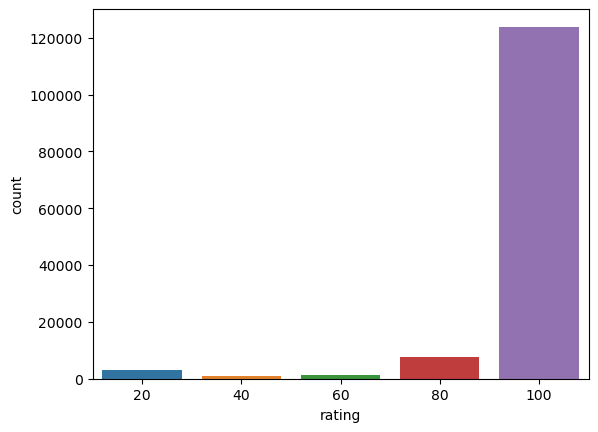

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = df['rating'])
plt.show()

Данные получились чрезвычайно несблансирвоанные, очевидно на сайте посетители оставляют в основном положительные отзывы.

100 баллов - это 5 звезд, 80 - 4 звезды, 60 - 3 звезды, 40 - 2 звезды и 20 - одна. Для простоты задачи 60, 80 и 100 будем считать положительным отзывом, а 40 и 20 - отрицательным.

In [7]:
rating_mapper = {100:1, 80:1, 60:1, 40:0, 20:0}
df['rating'] = df['rating'].replace(rating_mapper)

In [8]:
df['rating'].value_counts(normalize=True)

1    0.970575
0    0.029425
Name: rating, dtype: float64

Немного поменяем формат даты и посмотрим статистику отзывов по датам

In [9]:
import datetime
months = ["января", "февраля", "марта", "апреля", "мая", "июня", "июля", "августа", "сентября", "октября", "ноября",
              "декабря"]
def date_format(date):
    year = int(date.split(' ')[2])
    month = int(months.index(date.split(' ')[1]) + 1)
    day = int(date.split(' ')[0])
    return datetime.date(year, month, day)
df['date'] = df['date'].apply(date_format)   

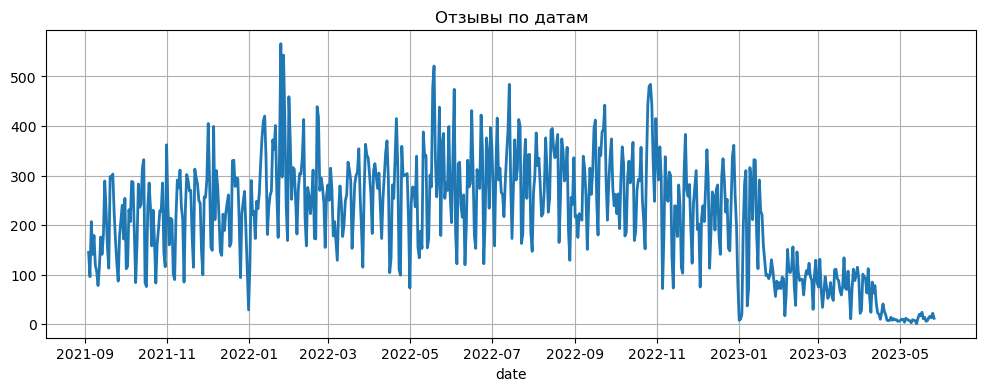

In [10]:
grouped_data = df.groupby('date')['user'].count()
grouped_data.plot(kind = 'line', figsize = (12,4), title = 'Отзывы по датам', grid = True, lw = 2)
plt.show()

Любопытно, что с февараля 23 года стало намного меньше отзывов

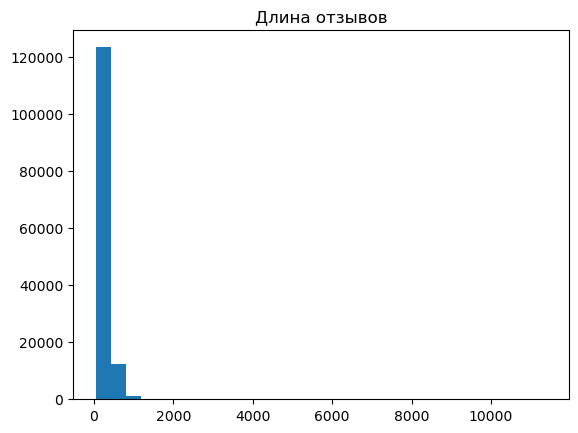

In [11]:
plt.title('Длина отзывов')
plt.hist(list(map(len, df['summary'])), bins=30)
plt.show()

# 1.2 Preprocessing текста

В рамках Preprocessing разобъем текст на токены, удалим стоп слова и цифры и приведем все слова в стандартную грамматическую форму. Словарь со стоп-словами немного дополним, тем что есть в нашем датасете.

In [12]:
import string
import nltk
import re
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stop_words.extend(['просто','вообще','она', 'такой', 'который', 'данный', 'этот', 'её', 'этот',
                  'это','эта', 'очень', 'мой', 'твой', 'его', 'наш', 'их','браво', 'здравствуйте', 
                   'спасибо' ,'свой', 'один', 'ещё', 'всё'])

In [14]:
import pymorphy2 
morph = pymorphy2.MorphAnalyzer()

def tokenization(data):
    
    texts = []
    labels = []
    for indx, user, date, rating, target,summary in data.itertuples():
        text_lower = summary.lower()
        text_lower = re.sub(r'[0-9]+', '', text_lower)
        text_lower = text_lower.replace('«','"')
        text_lower = text_lower.replace('»','"')
        tokens = word_tokenizer.tokenize(text_lower)
        tokens = [morph.parse(word)[0].normal_form for word in tokens]
        tokens = [word for word in tokens if(word not in string.punctuation and word not in stop_words)]
        texts.append(' '.join(tokens))
        labels.append(rating)
    
    return texts, labels

In [16]:
texts, labels = tokenization(df)

In [17]:
len(texts)

136890

In [18]:
texts[70:74]

['прийти валентина петрович жалоба тазобедренный сустав понравиться подход пациент выслушать жалоба внимательно довольно быстро поставить диагноз назначить лечение большой квалифицировать врач выражать огромный благодарность качественно оказать помощь',
 'хороший клиника огромный благодарность весь персонал добрый внимательный отношение каждый пациент приём проходить максимально комфортный обстановка впечатление клиника положительный',
 'давно встречать отличный доктор олег семёнович семейный доктор ребёнок год пользоваться рекомендация проблема огромный',
 'делать лазерный операция клиника белоглазов больно страшно весело )) доктор шутить подбадривать медсестра смеяться общий комфортно центр понравиться уютный чисто кабинет очередь застать второй консультация повод планирование операция дедушка палочка объяснимый очередь']

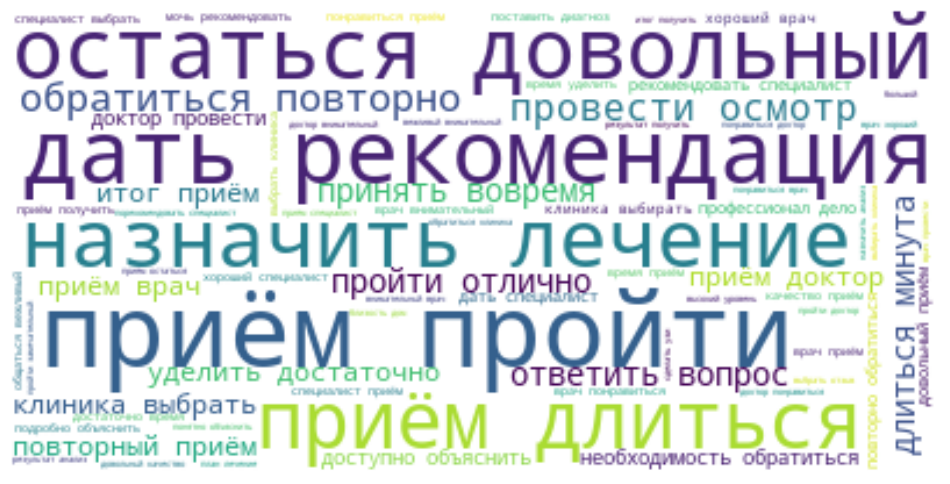

In [19]:
from wordcloud import WordCloud

wordcl = ' '.join(texts)

wordcloud = WordCloud(background_color="white").generate(wordcl)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Облако слов пожтверждает, что большинство отзывов положительные.


# Часть 2. NLP.

Разобьем преобразованные тексты на train/test

In [20]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, labels, test_size=0.2, 
                                                            random_state=42)

print(len(train_texts))
print(len(test_texts))
print(len(train_y))
print(len(test_y))

109512
27378
109512
27378


Дальше будем подбирать параметры для векторизации слов с помощью TfidfVectorizer через точность оценки тональности всего отзыва. В качестве метрики для точности оценки тональности через Logistic Regression будем использовать F1.

Параметры для подбора:

Для **TfidfVectorizer:**
1. max_df - объем словаря для построения векторов (отбрасываются часто встречающиеся слова выше указанного параметра)
2. min_df - объем словаря для построения векторов (отбрасываются редко встречающиеся слова ниже указанного параметра)
3. ngram_range - верхняя и нижняя граница для n-gramm

Для **LogisticRegression:**

Посмотрим только на два параметра - на веса классов (несбалансирован датасет) и на способ регуляризации

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features = 500, norm = None).fit(train_texts)
clf = LogisticRegression(solver = 'liblinear')

pipe = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])

param_grid = {'vectorizer__max_df':(0.5,0.75, 1),
              'vectorizer__min_df': (0.01, 0.1),
              'vectorizer__ngram_range':[(1,2), (2,2), (1,3)],
              'classifier__class_weight':[{1: 0.02, 0: 0.98},
                                          {1: 0.3, 0: 0.7},
                                          {1: 0.5, 0: 0.5}
                                         ],
              'classifier__penalty': ('l1', 'l2','elasticnet')
             }

grid_tf_idf = GridSearchCV(pipe, param_grid=param_grid, cv = 2, scoring = 'f1_macro', verbose=False)
grid_tf_idf.fit(train_texts,train_y)

grid_tf_idf.best_estimator_.get_params()

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(max_df=0.75, max_features=500, min_df=0.01, ngram_range=(1, 3),
                   norm=None)),
  ('classifier',
   LogisticRegression(class_weight={0: 0.7, 1: 0.3}, penalty='l1',
                      solver='liblinear'))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(max_df=0.75, max_features=500, min_df=0.01, ngram_range=(1, 3),
                 norm=None),
 'classifier': LogisticRegression(class_weight={0: 0.7, 1: 0.3}, penalty='l1',
                    solver='liblinear'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 0.75,
 'vectorizer__max_features': 500,
 'vectorizer__min_df': 0.01,
 'vectorizer__ngram_range': (1, 3),
 'vectorizer__norm': None,
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_i

Посмотрим, какие результаты даст модель с подобранными параметрами.

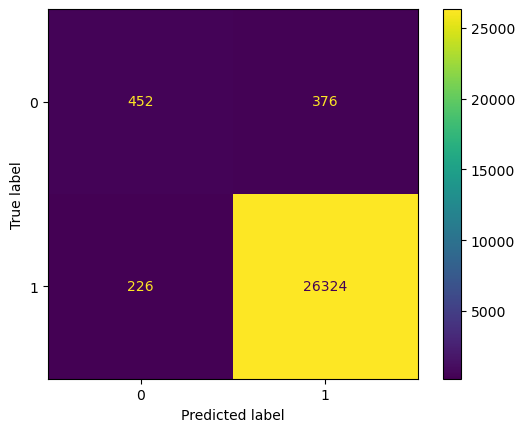

In [22]:
from sklearn import metrics

y_pred_tf_idf = grid_tf_idf.predict(test_texts)

metrics.ConfusionMatrixDisplay.from_predictions(test_y, y_pred_tf_idf)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_tf_idf))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       828
           1       0.99      0.99      0.99     26550

    accuracy                           0.98     27378
   macro avg       0.83      0.77      0.79     27378
weighted avg       0.98      0.98      0.98     27378



Модель смогла предсказать чуть больше половины всех негативных отзывов. Не совсем идеальный результат, но наверное для такой простой модели это может быть и неполохо.

Так как каждый признак - это отдельное слово, то мы можем посмотреть, какие топ-слова (или топ-биграммы/триграммы) определяют принадлженость к классу 1 (положительный отзыв) и наоборот.

Коээфициенты регрессии не показывают прямого эффекта на финальное значение целевой переменной, но сравнивая их между собой можно выявить те, которые имеют максимальное значение (определяют положительный отзыв) и минимальное значение (определяют отрицательный отзыв).

Коээфициенты можно рассматривать в начальном виде или "очищенные" от логарфима.

In [26]:
import numpy as np
coeff = pd.DataFrame(zip(grid_tf_idf.best_estimator_.named_steps['vectorizer'].get_feature_names_out(),
                        grid_tf_idf.best_estimator_.named_steps['classifier'].coef_[0]),
                     columns = ['word', 'coeff']
                    )
coeff = coeff.set_index('word')
coeff['odds'] = np.exp(coeff['coeff'])
coeff

,coeff,odds
word,,
администратор,-0.022855,0.977404
аккуратно,0.254032,1.289212
аккуратный,0.046887,1.048003
александр,0.074052,1.076863
александрович,0.086310,1.090144
...,...,...
чуткий,0.334029,1.396583
чётко,0.406609,1.501717
электронный,0.066959,1.069252


### Топ-30 слов или биграмов, наличие которых вероятнее всего будет являться признаком положительного отзыва

Мне кажется здесь модель сработала неплохо и выявила те качества и/или действия клиник, врачей, которые находят положительный отзыв среди пациентов. 

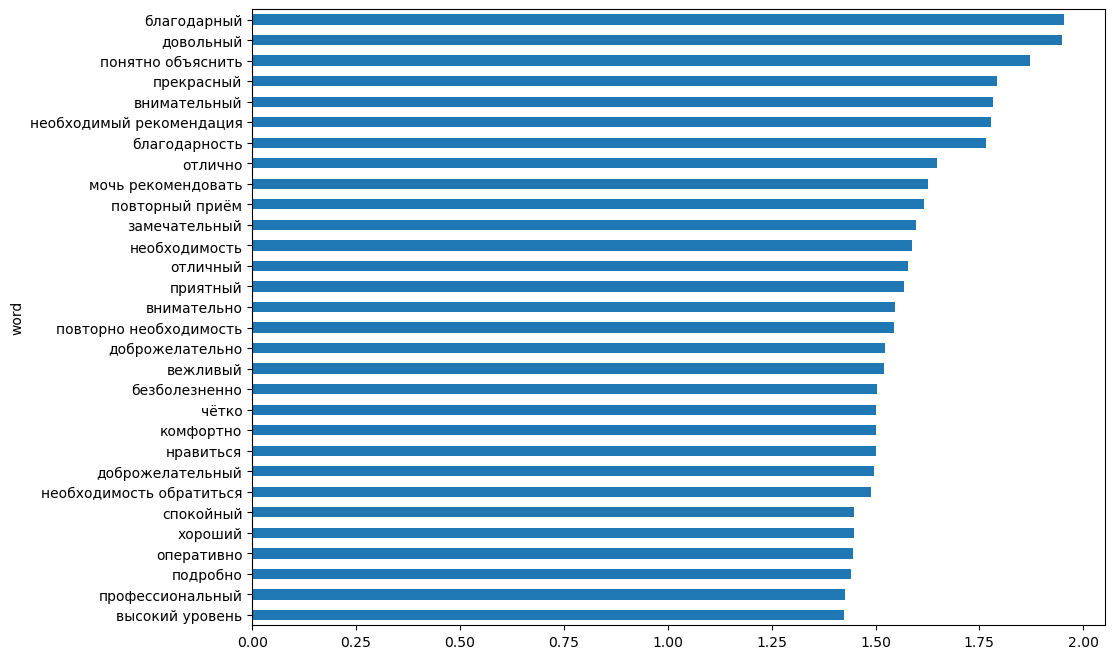

In [27]:
fig = plt.figure(figsize = (11,8))
max_coeff = coeff['odds'].nlargest(30).sort_values()
max_coeff.plot(kind = 'barh')
plt.show()

### Топ-30 слов или биграмов, наличие которых вероятнее всего будет являться признаком отризательного отзыва

Слова, которые соответсвуют минимальным коэффициентам в LogisticRegression и которые должны максимально влиять на вероятность отнесения к негативному отзыву, дают не столько легко интерпретируемые результаты. Есть много слов или словосочетаний, которые вроде бы несут положительный смысл, но являются частью отрицательных отзывов.

Одно очевидно, в большинтсве отрицательных отзывов поднималься вопрос о несостоятельности финансовых вложений в лечение :) "деньга" в топе-наоброт!

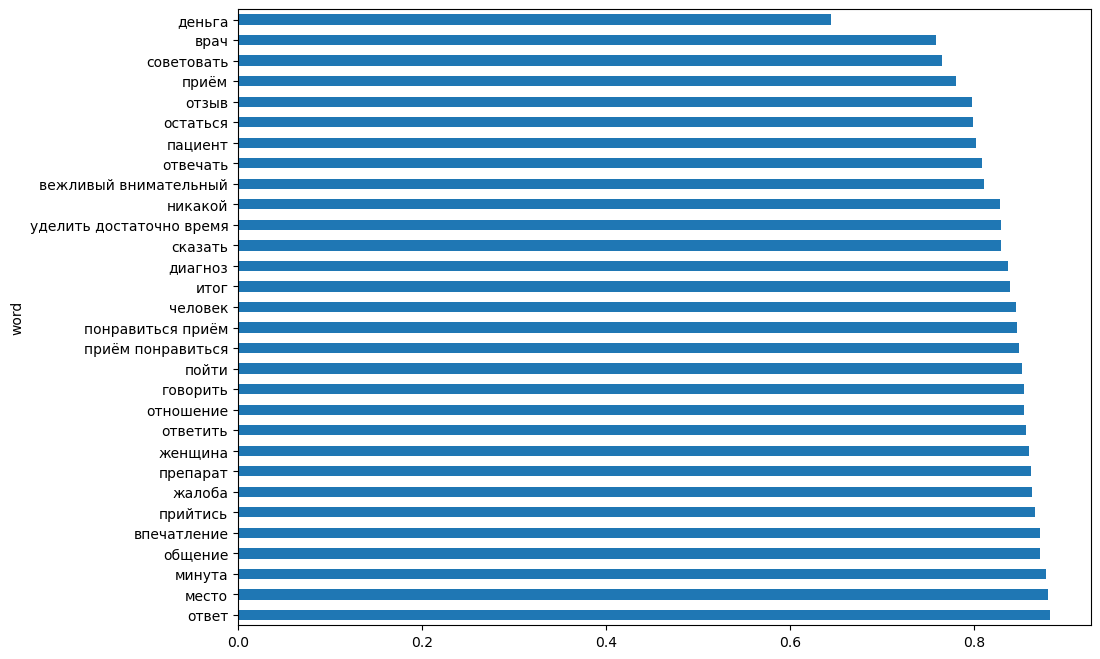

In [28]:
fig = plt.figure(figsize = (11,8))
min_coeff = coeff['odds'].nsmallest(30).sort_values(ascending = False)
min_coeff.plot(kind = 'barh')
plt.show()

# Финальные выводы:

Определение тональности для отзывов, векеторизиванных с помощью TfidfVectorizer, дало как ожидаемо хорошие результаты для доминириующего класса положительных отзывов. Для отрицательных отзывов результаты средние. 

Примерно похожий результат получился и для анализа слов/n-граммов, которые вносят наибольший вклад к отнесению к классу: для полодителльныхз отзывов подобрались вроде бы логичные слова, для отрицательных - не совсем. Сказывается, скорее всего, отсутвие частицы НЕ. Но основная претензия понятна - не соответвие качества цене!